In [1]:
import csv
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
RANDOM_SEED = 42
import psutil
import os

# FCNN
Specify each path

In [2]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'

Set number of classifications

In [3]:
NUM_CLASSES = 6

# input length

In [4]:
TIME_STEPS = 16
DIMENSION = 2

# Load learning data

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# model building

In [8]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION)), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])


In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │             792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,108 (4.33 KB)

 Trainable params: 1,108 (4.33 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early termination
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model training

Epoch 1/1000
 1/49 ━━━━━━━━━━━━━━━━━━━━ 26s 543ms/step - accuracy: 0.1641 - loss: 1.7295
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1658 - loss: 1.7410 - val_accuracy: 0.2427 - val_loss: 1.6837
Epoch 2/1000
 1/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1719 - loss: 1.7344
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2272 - loss: 1.6762 - val_accuracy: 0.2749 - val_loss: 1.6117
Epoch 3/1000
 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2891 - loss: 1.6433
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2682 - loss: 1.6311 - val_accuracy: 0.3000 - val_loss: 1.5587
Epoch 4/1000
 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3672 - loss: 1.5339
Epoch 4: saving model to model/point_history

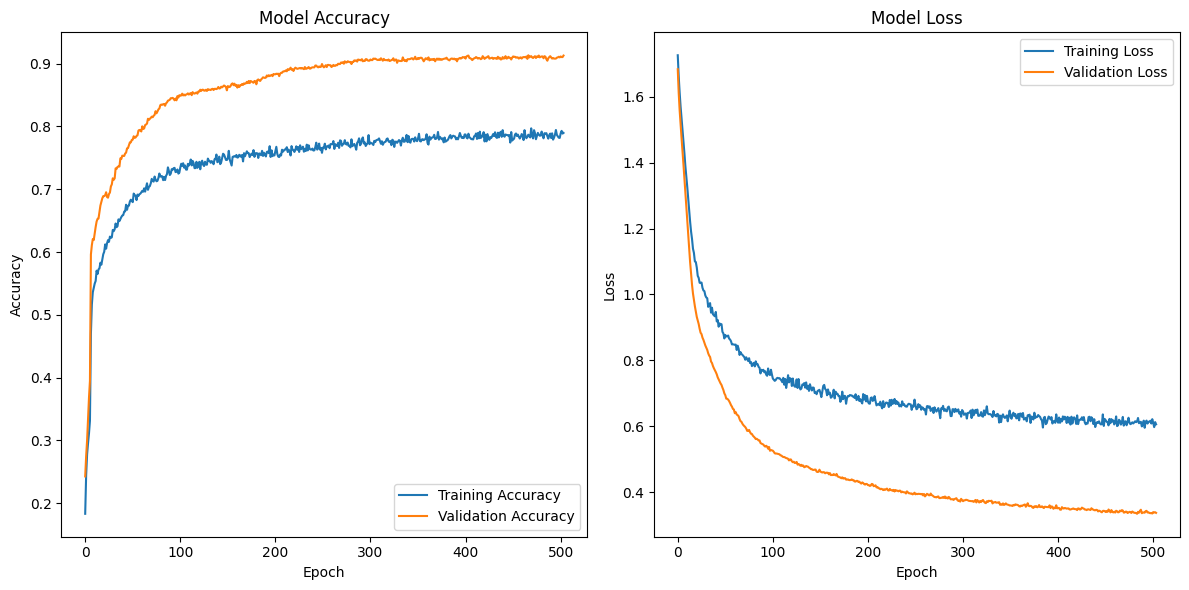

In [12]:

start_time = time.time()

# Get current process memory usage
process = psutil.Process(os.getpid())

# Measure memory usage before training FFNN
memory_before = process.memory_info().rss / 1024 ** 2  # Convert to MB

history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)


end_time = time.time()
training_time_lstm = end_time - start_time
print(f"FFNN Training Time: {training_time_lstm:.2f} seconds")

# Measure memory usage after training FFNN
memory_after = process.memory_info().rss / 1024 ** 2  # Convert to MB
memory_usage_ffnn = memory_after - memory_before
print(f"FFNN Memory Usage: {memory_usage_ffnn:.2f} MB")


# Plotting accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[0.         0.00102274 0.0077377  0.74377775 0.0207611  0.22670075]
3


# confusion matrix

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step


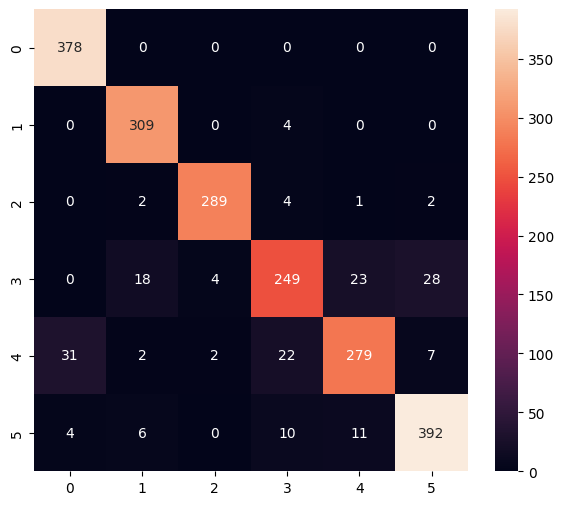

Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       378
           1       0.92      0.99      0.95       313
           2       0.98      0.97      0.97       298
           3       0.86      0.77      0.82       322
           4       0.89      0.81      0.85       343
           5       0.91      0.93      0.92       423

    accuracy                           0.91      2077
   macro avg       0.91      0.91      0.91      2077
weighted avg       0.91      0.91      0.91      2077



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-LiteConvert to model for

In [16]:
# Save as a model for inference only
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [17]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [18]:
# Transform the model (quantize
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Jhevish\AppData\Local\Temp\tmpsv7t0lj7\assets


INFO:tensorflow:Assets written to: C:\Users\Jhevish\AppData\Local\Temp\tmpsv7t0lj7\assets


Saved artifact at 'C:\Users\Jhevish\AppData\Local\Temp\tmpsv7t0lj7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1714019116032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1714019118672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1714019175936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1714019178576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1714019181040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1714019183328: TensorSpec(shape=(), dtype=tf.resource, name=None)


6512

# Reasoning test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get input/output tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 488 μs


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.         0.00102274 0.00773771 0.74377763 0.0207611  0.22670095]
3
